# Імпортуємо всі необхідні бібліотеки

In [2]:
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

from keras_tuner.tuners import BayesianOptimization


# Визначаємо глобальні змінні

In [45]:
SIZE = 224
BATCH = 32

# Прописую всі необхідні допоміжні функціі

In [64]:
def history_plot(history):

    mae = history.history['mae']
    val_mae = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    plt.plot(epochs, mae)
    plt.plot(epochs, val_mae)
    plt.title('Training and validation mae')
    plt.legend(['Training mae', 'Validation mae'])
    plt.figure()

    plt.plot(epochs,loss)
    plt.plot(epochs,val_loss)
    plt.title('Training and validation loss')
    plt.legend(['Training Loss','Validation Loss'])
    plt.figure()

def define_learning_rate(epoch, history, epoch_step, start_lr = 1e-6, stop_lr = 1e-2, view = 10):
    
    lrs = start_lr * (10 ** (np.arange(epoch) / epoch_step))
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.semilogx(lrs, history.history["loss"])
    plt.tick_params('both', length=10, width=1, which='both')
    plt.axis([start_lr, stop_lr, 0, view])


def load_and_resize_image(image_path, target_size=(224, 224)):
    image = cv2.imread(image_path)
    image = cv2.resize(image, target_size)
    return image


def load_data(data_directory):
    images = []
    targets = []

    for folder in os.listdir(data_directory):
        folder_path = os.path.join(data_directory, folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                image_path = os.path.join(folder_path, filename)
                if image_path.endswith('.png'):
                    resized_image = load_and_resize_image(image_path, target_size=(SIZE, SIZE))
                    images.append(resized_image)
                    targets.append(float(folder))

    return np.array(images), np.array(targets)

# Із вже підготовлених зображень формую тренувальні та тестові массиви зображень та їх кути відповідно до назв каталогів

In [16]:
train_directory = '/Users/aleksejkitajskij/Desktop/invoices_rotated/images/work_img/train'
test_directory = '/Users/aleksejkitajskij/Desktop/invoices_rotated/images/work_img/test'

X_train, y_train = load_data(train_directory)
X_test, y_test = load_data(test_directory)

# Базова модель

### Будую просту базову модель із переданим колбеком lr_schedule, в якому поступово збільшуєтся learning rate. В подальшому графіку, за допомогою збережених данних в history, визначаємо оптимальне значення lr 

In [47]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
lambda epoch: 1e-8 * 10**(epoch / 20))

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=BATCH,
                    validation_data = (X_test, y_test), 
                    callbacks=[lr_schedule, early_stopping_callback])


Epoch 1/100
18/18 [==============================] - 4s 185ms/step - loss: 1718.3929 - mse: 1718.3929 - val_loss: 1585.0627 - val_mse: 1585.0627 - lr: 1.0000e-08
Epoch 2/100
18/18 [==============================] - 3s 161ms/step - loss: 1395.9515 - mse: 1395.9515 - val_loss: 1267.8521 - val_mse: 1267.8521 - lr: 1.1220e-08
Epoch 3/100
18/18 [==============================] - 3s 157ms/step - loss: 1102.7042 - mse: 1102.7042 - val_loss: 982.3748 - val_mse: 982.3748 - lr: 1.2589e-08
Epoch 4/100
18/18 [==============================] - 3s 157ms/step - loss: 853.6811 - mse: 853.6811 - val_loss: 751.7394 - val_mse: 751.7394 - lr: 1.4125e-08
Epoch 5/100
18/18 [==============================] - 3s 157ms/step - loss: 657.7058 - mse: 657.7058 - val_loss: 572.6157 - val_mse: 572.6156 - lr: 1.5849e-08
Epoch 6/100
18/18 [==============================] - 3s 163ms/step - loss: 506.8173 - mse: 506.8173 - val_loss: 445.4690 - val_mse: 445.4690 - lr: 1.7783e-08
Epoch 7/100
18/18 [=======================

### На данному графіку видно що "турбулентність" десь між значеннями -07 та -06

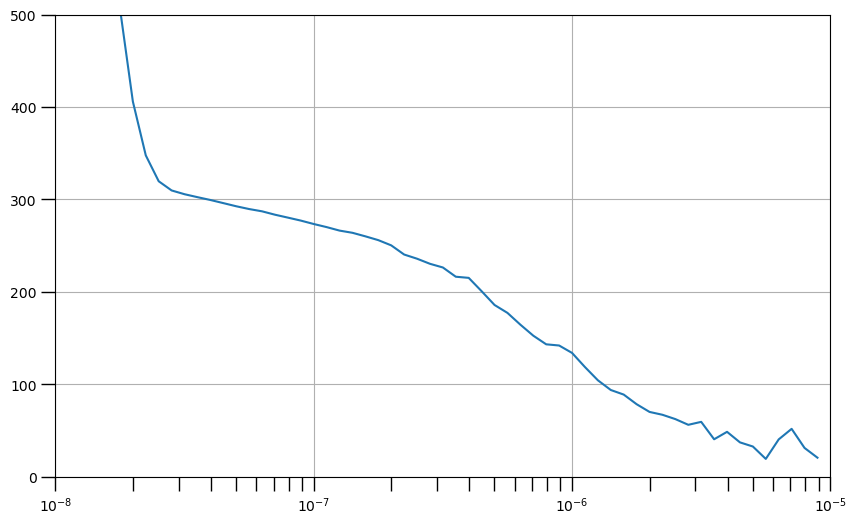

In [49]:
define_learning_rate(epoch = 60, history = history, epoch_step = 20, start_lr = 1e-8, stop_lr = 1e-5, view = 500)

### Беру середнє значення для використанням в якості lr в подальших моделях

In [50]:
0.00000055

5.5e-07

### Перевіряю ефективність визначеного lr та додаю колбек reduce_lr для зменьшення швидкості навчання при виході на плато. Із основних методів регулярізації поки використовуємо лише early_stopping_callback

In [55]:
input_layer = Input(shape=(SIZE, SIZE, 3))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)

x = Dense(64, activation='relu')(x)

output_layer = Dense(1)(x)

model2 = Model(inputs=input_layer, outputs=output_layer)


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-8,
    verbose=1
)

checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                    monitor="val_loss",
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    verbose=1)

model2.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00000055), loss='mean_absolute_error', metrics=['mae'])
history2 = model2.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=BATCH,
                    validation_data = (X_test, y_test), 
                    callbacks=[reduce_lr, early_stopping_callback, model_checkpoint])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 16.2783 - mae: 16.2783
Epoch 1: val_loss improved from inf to 14.08627, saving model to model_checkpoints/cp.ckpt
18/18 [==============================] - 4s 198ms/step - loss: 16.2783 - mae: 16.2783 - val_loss: 14.0863 - val_mae: 14.0863 - lr: 5.5000e-07
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 14.0214 - mae: 14.0214
Epoch 2: val_loss improved from 14.08627 to 12.59141, saving model to model_checkpoints/cp.ckpt
18/18 [==============================] - 4s 206ms/step - loss: 14.0214 - mae: 14.0214 - val_loss: 12.5914 - val_mae: 12.5914 - lr: 5.5000e-07
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 12.6855 - mae: 12.6855
Epoch 3: val_loss improved from 12.59141 to 12.29295, saving model to model_checkpoints/cp.ckpt
18/18 [==============================] - 3s 192ms/step - loss: 12.6855 - mae: 12.6855 - val_loss: 12.2930 - val_mae: 12.2930 - lr: 5.5000e-07
Epoch 4/100
18/

In [62]:
model2.evaluate(X_test, y_test)

4/4 [==============================] - 1s 108ms/step - loss: 4.1682 - mae: 4.1682


[4.168227672576904, 4.168227672576904]

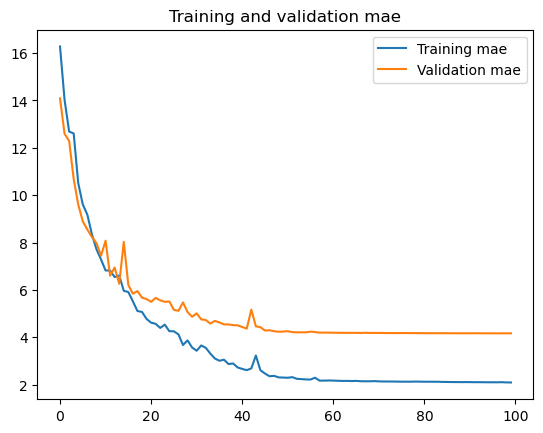

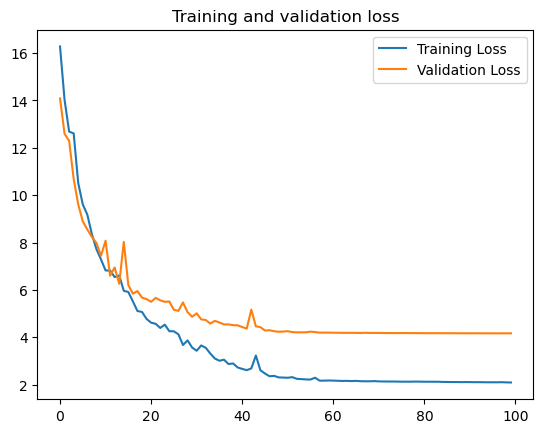

<Figure size 640x480 with 0 Axes>

In [65]:
history_plot(history2)

### Також перевіримо чекпоінт що зберігся на 97 епосі

In [85]:
cloned_model = tf.keras.models.clone_model(model2)
cloned_model.load_weights(checkpoint_path)
cloned_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00000055), loss='mean_absolute_error', metrics=['mae'])

In [86]:
cloned_model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 138ms/step - loss: 4.1665 - mae: 4.1665


[4.166451930999756, 4.166451930999756]

# Основна модель

### Будуємо тюнер з використанням Баевського оптимізатора, який за допомогою Гаусівського розподілу та Теорії Ймовірності має знайти оптимальні параметри моделі

### В якості регуляризації використовуємо EarlyStopping, що має зупинити навчання в разі виходу на плато за метрикою val_mae; шари Dropout що відключатимуть по 30 відсоткив нейронів в кожній епосі

In [ ]:
def build_custom_model(liers1, liers2, units1, units2):

    inputs = tf.keras.layers.Input(shape=(SIZE, SIZE, 3), name="input_layer")
    
    x = tf.keras.layers.Conv2D(units1 / 2, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    for i in range(1, liers1 + 1):
        x = tf.keras.layers.Conv2D(int(units1 * i), (3, 3), activation='relu')(x)
        x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Flatten()(x)

    for j in range(liers2, 0, -1):
        x = tf.keras.layers.Dense(int(units2 / j), activation='relu')(x)
        x = tf.keras.layers.Dropout(rate=0.3)(x)
    
    outputs = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        loss='mean_absolute_error', 
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.00000055), 
        metrics=['mae'])

    return model


def build_model(hp):
    liers1 = hp.Choice("liers1", [1, 2, 3])
    liers2 = hp.Choice("liers2", [1, 2, 3])
    units1 = hp.Choice("units1", [16, 32, 64, 128])
    units2 = hp.Choice("units2", [64, 128, 256, 512])
    
    model = build_custom_model(liers1 = liers1, liers2 = liers2, units1 = units1, units2 = units2)

    return model


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-8,
    verbose=1
)

Trial 10 Complete [00h 01m 50s]
val_mae: 11.553166389465332

Best val_mae So Far: 6.04791259765625
Total elapsed time: 00h 35m 25s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


### Судячи з базової моделі 50 є достатнім значенням епох, але оскільки я ставлю будуватись модель на ніч, то залишу 100. Уникнути перенавченості мають попередні заходи регулярізації

In [ ]:
tuner = BayesianOptimization(
    build_model,
    objective="val_mae",
    num_initial_points=5,
    max_trials=10,
    directory="Kytaiskyi",
    project_name="BayesianOptimization"
)

history3 = tuner.search(
    X_train, y_train,
    epochs=100,
    validation_data = (X_test, y_test), 
    callbacks=[early_stopping_callback, reduce_lr]
)

### Оскільки модель з тюнера не перевершила базову модель (4.1 проти 6.0) розширюємо діапазон пошуку та встановлюємо кількість епох на 1000 аби будування завершилось по колбеку

In [58]:
tuner_model = BayesianOptimization(
    build_model,
    objective="val_mae",
    num_initial_points=5,
    max_trials=30,
    directory="Kytaiskyi",
    project_name="BayesianOptimization"
)

history_tuner = tuner_model.search(
    X_train, y_train,
    epochs=1000,
    validation_data = (X_test, y_test), 
    callbacks=[early_stopping_callback, reduce_lr]
)

Trial 30 Complete [00h 09m 57s]
val_mae: 3.5284438133239746

Best val_mae So Far: 2.9861581325531006
Total elapsed time: 02h 13m 06s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [66]:
final_model = tuner_model.get_best_models(num_models=1)[0]

In [80]:
final_model.evaluate(X_test, y_test)

4/4 [==============================] - 1s 183ms/step - loss: 2.9862 - mae: 2.9862


[2.9861581325531006, 2.9861581325531006]

In [87]:
final_model.save('model.h5')

/Users/aleksejkitajskij/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
